In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = True
enable_orig = False
enable_aug = False
enable_aug3 = True
max_training_samples = 200000
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-True-enable_orig-False-enable_aug-False-enable_aug3-True-max_training_samples-200000-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

5000
5000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


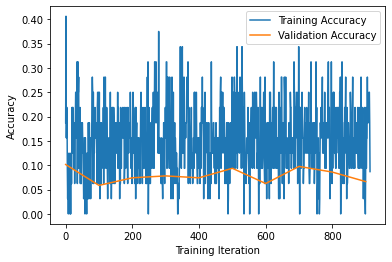

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.243 Validation Loss: 2.206 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.242 Validation Loss: 2.206 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.238 Validation Loss: 2.206 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.239 Validation Loss: 2.206 Accuracy: 0.000 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.238 Validation Loss: 2.206 Accuracy: 0.002 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.236 Validation Loss: 2.206 Accuracy: 0.001 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.235 Validation Loss: 2.206 Accuracy: 0.002 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.234 Validation Loss: 2.206 Accuracy: 0.003 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.234 Validation Loss: 2.206 Accuracy: 0.003 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.233 Validation Loss: 2.206 Accuracy: 0.008 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.233 Validation Loss: 2.206 Accuracy: 0.010 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.232 Validation Loss: 2.206 Accuracy: 0.013 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.231 Validation Loss: 2.206 Accuracy: 0.020 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.230 Validation Loss: 2.206 Accuracy: 0.026 Validation Accuracy: 0.000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.230 Validation Loss: 2.206 Accuracy: 0.026 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 14 Loss: 2.229 Validation Loss: 2.206 Accuracy: 0.030 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 15 Loss: 2.228 Validation Loss: 2.206 Accuracy: 0.034 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 16 Loss: 2.227 Validation Loss: 2.206 Accuracy: 0.037 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 17 Loss: 2.226 Validation Loss: 2.206 Accuracy: 0.042 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 18 Loss: 2.225 Validation Loss: 2.206 Accuracy: 0.048 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 19 Loss: 2.225 Validation Loss: 2.206 Accuracy: 0.048 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 20 Loss: 2.223 Validation Loss: 2.206 Accuracy: 0.051 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 21 Loss: 2.221 Validation Loss: 2.206 Accuracy: 0.055 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 22 Loss: 2.219 Validation Loss: 2.206 Accuracy: 0.055 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 23 Loss: 2.217 Validation Loss: 2.206 Accuracy: 0.060 Validation Accuracy: 0.000:  35%|███▌      | 14/40 [00:00<00:00, 93.11it/s]

Epoch: 0 Iteration: 23 Loss: 2.217 Validation Loss: 2.206 Accuracy: 0.060 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 24 Loss: 2.215 Validation Loss: 2.206 Accuracy: 0.062 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 25 Loss: 2.213 Validation Loss: 2.206 Accuracy: 0.064 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 26 Loss: 2.211 Validation Loss: 2.206 Accuracy: 0.066 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 27 Loss: 2.209 Validation Loss: 2.206 Accuracy: 0.070 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 28 Loss: 2.207 Validation Loss: 2.206 Accuracy: 0.073 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 29 Loss: 2.205 Validation Loss: 2.206 Accuracy: 0.077 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 30 Loss: 2.203 Validation Loss: 2.206 Accuracy: 0.080 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 31 Loss: 2.201 Validation Loss: 2.206 Accuracy: 0.083 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 32 Loss: 2.199 Validation Loss: 2.206 Accuracy: 0.084 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 33 Loss: 2.197 Validation Loss: 2.206 Accuracy: 0.084 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 34 Loss: 2.195 Validation Loss: 2.206 Accuracy: 0.084 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 35 Loss: 2.193 Validation Loss: 2.206 Accuracy: 0.089 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 36 Loss: 2.191 Validation Loss: 2.206 Accuracy: 0.095 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 37 Loss: 2.189 Validation Loss: 2.206 Accuracy: 0.098 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 38 Loss: 2.187 Validation Loss: 2.206 Accuracy: 0.096 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 39 Loss: 2.186 Validation Loss: 2.206 Accuracy: 0.087 Validation Accuracy: 0.000:  60%|██████    | 24/40 [00:00<00:00, 60.79it/s]

Epoch: 0 Iteration: 39 Loss: 2.186 Validation Loss: 2.206 Accuracy: 0.087 Validation Accuracy: 0.000: 100%|██████████| 40/40 [00:00<00:00, 86.09it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 2.184 Validation Loss: 2.209 Accuracy: 0.087 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 2.182 Validation Loss: 2.209 Accuracy: 0.087 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 2.181 Validation Loss: 2.209 Accuracy: 0.087 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 2.179 Validation Loss: 2.209 Accuracy: 0.086 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 2.177 Validation Loss: 2.209 Accuracy: 0.090 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 2.175 Validation Loss: 2.209 Accuracy: 0.093 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 2.173 Validation Loss: 2.209 Accuracy: 0.091 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 2.171 Validation Loss: 2.209 Accuracy: 0.095 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 2.170 Validation Loss: 2.209 Accuracy: 0.103 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 2.168 Validation Loss: 2.209 Accuracy: 0.120 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 2.166 Validation Loss: 2.209 Accuracy: 0.126 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 2.164 Validation Loss: 2.209 Accuracy: 0.128 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.163 Validation Loss: 2.209 Accuracy: 0.138 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 2.161 Validation Loss: 2.209 Accuracy: 0.145 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 2.158 Validation Loss: 2.209 Accuracy: 0.150 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 2.157 Validation Loss: 2.209 Accuracy: 0.154 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 2.154 Validation Loss: 2.209 Accuracy: 0.163 Validation Accuracy: 0.015:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 2.154 Validation Loss: 2.209 Accuracy: 0.163 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 17 Loss: 2.152 Validation Loss: 2.209 Accuracy: 0.166 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 18 Loss: 2.150 Validation Loss: 2.209 Accuracy: 0.168 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 19 Loss: 2.147 Validation Loss: 2.209 Accuracy: 0.172 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 20 Loss: 2.145 Validation Loss: 2.209 Accuracy: 0.180 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 21 Loss: 2.143 Validation Loss: 2.209 Accuracy: 0.184 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 22 Loss: 2.142 Validation Loss: 2.209 Accuracy: 0.180 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 23 Loss: 2.140 Validation Loss: 2.209 Accuracy: 0.177 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 24 Loss: 2.139 Validation Loss: 2.209 Accuracy: 0.183 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 25 Loss: 2.137 Validation Loss: 2.209 Accuracy: 0.184 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 26 Loss: 2.134 Validation Loss: 2.209 Accuracy: 0.181 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 27 Loss: 2.133 Validation Loss: 2.209 Accuracy: 0.185 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 28 Loss: 2.131 Validation Loss: 2.209 Accuracy: 0.188 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 29 Loss: 2.130 Validation Loss: 2.209 Accuracy: 0.180 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 30 Loss: 2.127 Validation Loss: 2.209 Accuracy: 0.176 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 31 Loss: 2.124 Validation Loss: 2.209 Accuracy: 0.186 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 32 Loss: 2.123 Validation Loss: 2.209 Accuracy: 0.192 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 33 Loss: 2.122 Validation Loss: 2.209 Accuracy: 0.201 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 34 Loss: 2.120 Validation Loss: 2.209 Accuracy: 0.196 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 35 Loss: 2.118 Validation Loss: 2.209 Accuracy: 0.200 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 36 Loss: 2.117 Validation Loss: 2.209 Accuracy: 0.206 Validation Accuracy: 0.015:  42%|████▎     | 17/40 [00:00<00:00, 166.53it/s]

Epoch: 1 Iteration: 36 Loss: 2.117 Validation Loss: 2.209 Accuracy: 0.206 Validation Accuracy: 0.015:  92%|█████████▎| 37/40 [00:00<00:00, 185.92it/s]

Epoch: 1 Iteration: 37 Loss: 2.114 Validation Loss: 2.209 Accuracy: 0.209 Validation Accuracy: 0.015:  92%|█████████▎| 37/40 [00:00<00:00, 185.92it/s]

Epoch: 1 Iteration: 38 Loss: 2.112 Validation Loss: 2.209 Accuracy: 0.209 Validation Accuracy: 0.015:  92%|█████████▎| 37/40 [00:00<00:00, 185.92it/s]

Epoch: 1 Iteration: 39 Loss: 2.111 Validation Loss: 2.209 Accuracy: 0.209 Validation Accuracy: 0.015:  92%|█████████▎| 37/40 [00:00<00:00, 185.92it/s]

Epoch: 1 Iteration: 39 Loss: 2.111 Validation Loss: 2.209 Accuracy: 0.209 Validation Accuracy: 0.015: 100%|██████████| 40/40 [00:00<00:00, 186.54it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 2.110 Validation Loss: 2.219 Accuracy: 0.209 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 2.108 Validation Loss: 2.219 Accuracy: 0.207 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 2.106 Validation Loss: 2.219 Accuracy: 0.207 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 2.104 Validation Loss: 2.219 Accuracy: 0.207 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 2.103 Validation Loss: 2.219 Accuracy: 0.207 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 2.100 Validation Loss: 2.219 Accuracy: 0.205 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 2.098 Validation Loss: 2.219 Accuracy: 0.208 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 2.095 Validation Loss: 2.219 Accuracy: 0.202 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 2.093 Validation Loss: 2.219 Accuracy: 0.200 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 2.091 Validation Loss: 2.219 Accuracy: 0.209 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 2.090 Validation Loss: 2.219 Accuracy: 0.210 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 2.088 Validation Loss: 2.219 Accuracy: 0.216 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 2.086 Validation Loss: 2.219 Accuracy: 0.216 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 2.083 Validation Loss: 2.219 Accuracy: 0.220 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 2.081 Validation Loss: 2.219 Accuracy: 0.229 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 2.079 Validation Loss: 2.219 Accuracy: 0.234 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 2.075 Validation Loss: 2.219 Accuracy: 0.243 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 2.074 Validation Loss: 2.219 Accuracy: 0.248 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 2.072 Validation Loss: 2.219 Accuracy: 0.255 Validation Accuracy: 0.027:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 2.072 Validation Loss: 2.219 Accuracy: 0.255 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 19 Loss: 2.070 Validation Loss: 2.219 Accuracy: 0.254 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 20 Loss: 2.067 Validation Loss: 2.219 Accuracy: 0.263 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 21 Loss: 2.065 Validation Loss: 2.219 Accuracy: 0.262 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 22 Loss: 2.064 Validation Loss: 2.219 Accuracy: 0.263 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 23 Loss: 2.061 Validation Loss: 2.219 Accuracy: 0.265 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 24 Loss: 2.057 Validation Loss: 2.219 Accuracy: 0.266 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 25 Loss: 2.055 Validation Loss: 2.219 Accuracy: 0.271 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 26 Loss: 2.050 Validation Loss: 2.219 Accuracy: 0.273 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 27 Loss: 2.048 Validation Loss: 2.219 Accuracy: 0.276 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 28 Loss: 2.046 Validation Loss: 2.219 Accuracy: 0.281 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 29 Loss: 2.044 Validation Loss: 2.219 Accuracy: 0.284 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 30 Loss: 2.042 Validation Loss: 2.219 Accuracy: 0.276 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 31 Loss: 2.041 Validation Loss: 2.219 Accuracy: 0.273 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 32 Loss: 2.037 Validation Loss: 2.219 Accuracy: 0.277 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 33 Loss: 2.035 Validation Loss: 2.219 Accuracy: 0.283 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 34 Loss: 2.031 Validation Loss: 2.219 Accuracy: 0.284 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 35 Loss: 2.029 Validation Loss: 2.219 Accuracy: 0.280 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 36 Loss: 2.028 Validation Loss: 2.219 Accuracy: 0.279 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 37 Loss: 2.026 Validation Loss: 2.219 Accuracy: 0.282 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 38 Loss: 2.023 Validation Loss: 2.219 Accuracy: 0.280 Validation Accuracy: 0.027:  48%|████▊     | 19/40 [00:00<00:00, 182.36it/s]

Epoch: 2 Iteration: 38 Loss: 2.023 Validation Loss: 2.219 Accuracy: 0.280 Validation Accuracy: 0.027:  98%|█████████▊| 39/40 [00:00<00:00, 191.71it/s]

Epoch: 2 Iteration: 39 Loss: 2.020 Validation Loss: 2.219 Accuracy: 0.295 Validation Accuracy: 0.027:  98%|█████████▊| 39/40 [00:00<00:00, 191.71it/s]

Epoch: 2 Iteration: 39 Loss: 2.020 Validation Loss: 2.219 Accuracy: 0.295 Validation Accuracy: 0.027: 100%|██████████| 40/40 [00:00<00:00, 192.74it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 2.016 Validation Loss: 2.243 Accuracy: 0.306 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 2.012 Validation Loss: 2.243 Accuracy: 0.315 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 2.008 Validation Loss: 2.243 Accuracy: 0.329 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 2.006 Validation Loss: 2.243 Accuracy: 0.332 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 2.007 Validation Loss: 2.243 Accuracy: 0.331 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 2.004 Validation Loss: 2.243 Accuracy: 0.337 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 2.006 Validation Loss: 2.243 Accuracy: 0.337 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 2.004 Validation Loss: 2.243 Accuracy: 0.340 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 2.003 Validation Loss: 2.243 Accuracy: 0.333 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 2.000 Validation Loss: 2.243 Accuracy: 0.326 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 1.994 Validation Loss: 2.243 Accuracy: 0.331 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 1.990 Validation Loss: 2.243 Accuracy: 0.331 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 1.985 Validation Loss: 2.243 Accuracy: 0.333 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 1.983 Validation Loss: 2.243 Accuracy: 0.331 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 1.981 Validation Loss: 2.243 Accuracy: 0.339 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 1.978 Validation Loss: 2.243 Accuracy: 0.341 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 1.976 Validation Loss: 2.243 Accuracy: 0.339 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 1.973 Validation Loss: 2.243 Accuracy: 0.347 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 1.971 Validation Loss: 2.243 Accuracy: 0.363 Validation Accuracy: 0.040:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 1.971 Validation Loss: 2.243 Accuracy: 0.363 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 19 Loss: 1.968 Validation Loss: 2.243 Accuracy: 0.372 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 20 Loss: 1.969 Validation Loss: 2.243 Accuracy: 0.365 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 21 Loss: 1.966 Validation Loss: 2.243 Accuracy: 0.373 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 22 Loss: 1.962 Validation Loss: 2.243 Accuracy: 0.374 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 23 Loss: 1.962 Validation Loss: 2.243 Accuracy: 0.372 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 24 Loss: 1.958 Validation Loss: 2.243 Accuracy: 0.375 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 25 Loss: 1.955 Validation Loss: 2.243 Accuracy: 0.387 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 26 Loss: 1.952 Validation Loss: 2.243 Accuracy: 0.393 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 27 Loss: 1.950 Validation Loss: 2.243 Accuracy: 0.392 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 28 Loss: 1.946 Validation Loss: 2.243 Accuracy: 0.395 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 29 Loss: 1.942 Validation Loss: 2.243 Accuracy: 0.398 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 30 Loss: 1.941 Validation Loss: 2.243 Accuracy: 0.399 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 31 Loss: 1.940 Validation Loss: 2.243 Accuracy: 0.391 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 32 Loss: 1.942 Validation Loss: 2.243 Accuracy: 0.384 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 33 Loss: 1.939 Validation Loss: 2.243 Accuracy: 0.401 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 34 Loss: 1.937 Validation Loss: 2.243 Accuracy: 0.407 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 35 Loss: 1.938 Validation Loss: 2.243 Accuracy: 0.399 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 36 Loss: 1.937 Validation Loss: 2.243 Accuracy: 0.395 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 37 Loss: 1.937 Validation Loss: 2.243 Accuracy: 0.392 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 38 Loss: 1.934 Validation Loss: 2.243 Accuracy: 0.386 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 39 Loss: 1.931 Validation Loss: 2.243 Accuracy: 0.394 Validation Accuracy: 0.040:  48%|████▊     | 19/40 [00:00<00:00, 188.71it/s]

Epoch: 3 Iteration: 39 Loss: 1.931 Validation Loss: 2.243 Accuracy: 0.394 Validation Accuracy: 0.040: 100%|██████████| 40/40 [00:00<00:00, 199.18it/s]

Epoch: 3 Iteration: 39 Loss: 1.931 Validation Loss: 2.243 Accuracy: 0.394 Validation Accuracy: 0.040: 100%|██████████| 40/40 [00:00<00:00, 197.26it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 1.927 Validation Loss: 2.289 Accuracy: 0.404 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 1.925 Validation Loss: 2.289 Accuracy: 0.417 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 1.925 Validation Loss: 2.289 Accuracy: 0.422 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 1.921 Validation Loss: 2.289 Accuracy: 0.415 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 1.918 Validation Loss: 2.289 Accuracy: 0.406 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 1.918 Validation Loss: 2.289 Accuracy: 0.399 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 1.914 Validation Loss: 2.289 Accuracy: 0.407 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 1.912 Validation Loss: 2.289 Accuracy: 0.416 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 1.910 Validation Loss: 2.289 Accuracy: 0.423 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 1.907 Validation Loss: 2.289 Accuracy: 0.423 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 1.906 Validation Loss: 2.289 Accuracy: 0.424 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 1.901 Validation Loss: 2.289 Accuracy: 0.420 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 1.899 Validation Loss: 2.289 Accuracy: 0.421 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 1.898 Validation Loss: 2.289 Accuracy: 0.428 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 1.894 Validation Loss: 2.289 Accuracy: 0.434 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 1.890 Validation Loss: 2.289 Accuracy: 0.450 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 1.884 Validation Loss: 2.289 Accuracy: 0.458 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 1.881 Validation Loss: 2.289 Accuracy: 0.457 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 1.877 Validation Loss: 2.289 Accuracy: 0.462 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 1.876 Validation Loss: 2.289 Accuracy: 0.460 Validation Accuracy: 0.054:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 1.876 Validation Loss: 2.289 Accuracy: 0.460 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 20 Loss: 1.869 Validation Loss: 2.289 Accuracy: 0.467 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 21 Loss: 1.867 Validation Loss: 2.289 Accuracy: 0.473 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 22 Loss: 1.864 Validation Loss: 2.289 Accuracy: 0.476 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 23 Loss: 1.862 Validation Loss: 2.289 Accuracy: 0.468 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 24 Loss: 1.857 Validation Loss: 2.289 Accuracy: 0.474 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 25 Loss: 1.852 Validation Loss: 2.289 Accuracy: 0.465 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 26 Loss: 1.850 Validation Loss: 2.289 Accuracy: 0.452 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 27 Loss: 1.844 Validation Loss: 2.289 Accuracy: 0.462 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 28 Loss: 1.843 Validation Loss: 2.289 Accuracy: 0.460 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 29 Loss: 1.841 Validation Loss: 2.289 Accuracy: 0.462 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 30 Loss: 1.836 Validation Loss: 2.289 Accuracy: 0.463 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 31 Loss: 1.832 Validation Loss: 2.289 Accuracy: 0.458 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 32 Loss: 1.828 Validation Loss: 2.289 Accuracy: 0.459 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 33 Loss: 1.823 Validation Loss: 2.289 Accuracy: 0.466 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 34 Loss: 1.821 Validation Loss: 2.289 Accuracy: 0.463 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 35 Loss: 1.817 Validation Loss: 2.289 Accuracy: 0.466 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 36 Loss: 1.815 Validation Loss: 2.289 Accuracy: 0.480 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 37 Loss: 1.812 Validation Loss: 2.289 Accuracy: 0.473 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 38 Loss: 1.810 Validation Loss: 2.289 Accuracy: 0.476 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 39 Loss: 1.805 Validation Loss: 2.289 Accuracy: 0.450 Validation Accuracy: 0.054:  50%|█████     | 20/40 [00:00<00:00, 191.46it/s]

Epoch: 4 Iteration: 39 Loss: 1.805 Validation Loss: 2.289 Accuracy: 0.450 Validation Accuracy: 0.054: 100%|██████████| 40/40 [00:00<00:00, 199.48it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 1.808 Validation Loss: 2.366 Accuracy: 0.445 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 1.805 Validation Loss: 2.366 Accuracy: 0.451 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 1.800 Validation Loss: 2.366 Accuracy: 0.458 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 1.796 Validation Loss: 2.366 Accuracy: 0.455 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.794 Validation Loss: 2.366 Accuracy: 0.452 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 1.788 Validation Loss: 2.366 Accuracy: 0.465 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 1.786 Validation Loss: 2.366 Accuracy: 0.465 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 1.782 Validation Loss: 2.366 Accuracy: 0.461 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 1.775 Validation Loss: 2.366 Accuracy: 0.470 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 1.773 Validation Loss: 2.366 Accuracy: 0.491 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 1.770 Validation Loss: 2.366 Accuracy: 0.494 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 1.771 Validation Loss: 2.366 Accuracy: 0.489 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 1.767 Validation Loss: 2.366 Accuracy: 0.494 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 1.768 Validation Loss: 2.366 Accuracy: 0.493 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 1.763 Validation Loss: 2.366 Accuracy: 0.499 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 1.756 Validation Loss: 2.366 Accuracy: 0.504 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 1.752 Validation Loss: 2.366 Accuracy: 0.507 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 1.748 Validation Loss: 2.366 Accuracy: 0.517 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 1.747 Validation Loss: 2.366 Accuracy: 0.501 Validation Accuracy: 0.067:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 1.747 Validation Loss: 2.366 Accuracy: 0.501 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 19 Loss: 1.746 Validation Loss: 2.366 Accuracy: 0.503 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 20 Loss: 1.742 Validation Loss: 2.366 Accuracy: 0.500 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 21 Loss: 1.738 Validation Loss: 2.366 Accuracy: 0.502 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 22 Loss: 1.737 Validation Loss: 2.366 Accuracy: 0.495 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 23 Loss: 1.734 Validation Loss: 2.366 Accuracy: 0.498 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 24 Loss: 1.729 Validation Loss: 2.366 Accuracy: 0.498 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 25 Loss: 1.730 Validation Loss: 2.366 Accuracy: 0.488 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 26 Loss: 1.726 Validation Loss: 2.366 Accuracy: 0.483 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 27 Loss: 1.724 Validation Loss: 2.366 Accuracy: 0.473 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 28 Loss: 1.723 Validation Loss: 2.366 Accuracy: 0.484 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 29 Loss: 1.720 Validation Loss: 2.366 Accuracy: 0.475 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 30 Loss: 1.715 Validation Loss: 2.366 Accuracy: 0.478 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 31 Loss: 1.708 Validation Loss: 2.366 Accuracy: 0.477 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 32 Loss: 1.706 Validation Loss: 2.366 Accuracy: 0.473 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 33 Loss: 1.699 Validation Loss: 2.366 Accuracy: 0.487 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 34 Loss: 1.697 Validation Loss: 2.366 Accuracy: 0.488 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 35 Loss: 1.701 Validation Loss: 2.366 Accuracy: 0.480 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 36 Loss: 1.695 Validation Loss: 2.366 Accuracy: 0.488 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 37 Loss: 1.690 Validation Loss: 2.366 Accuracy: 0.493 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 38 Loss: 1.686 Validation Loss: 2.366 Accuracy: 0.494 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 39 Loss: 1.676 Validation Loss: 2.366 Accuracy: 0.493 Validation Accuracy: 0.067:  48%|████▊     | 19/40 [00:00<00:00, 189.35it/s]

Epoch: 5 Iteration: 39 Loss: 1.676 Validation Loss: 2.366 Accuracy: 0.493 Validation Accuracy: 0.067: 100%|██████████| 40/40 [00:00<00:00, 199.71it/s]

Epoch: 5 Iteration: 39 Loss: 1.676 Validation Loss: 2.366 Accuracy: 0.493 Validation Accuracy: 0.067: 100%|██████████| 40/40 [00:00<00:00, 197.81it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 1.670 Validation Loss: 2.486 Accuracy: 0.488 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 1.666 Validation Loss: 2.486 Accuracy: 0.495 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 1.662 Validation Loss: 2.486 Accuracy: 0.499 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 1.660 Validation Loss: 2.486 Accuracy: 0.487 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 1.658 Validation Loss: 2.486 Accuracy: 0.478 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 1.651 Validation Loss: 2.486 Accuracy: 0.487 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 1.648 Validation Loss: 2.486 Accuracy: 0.480 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 1.644 Validation Loss: 2.486 Accuracy: 0.482 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 1.639 Validation Loss: 2.486 Accuracy: 0.480 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 1.633 Validation Loss: 2.486 Accuracy: 0.491 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 1.628 Validation Loss: 2.486 Accuracy: 0.501 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 1.627 Validation Loss: 2.486 Accuracy: 0.499 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 1.622 Validation Loss: 2.486 Accuracy: 0.500 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 1.619 Validation Loss: 2.486 Accuracy: 0.499 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 1.614 Validation Loss: 2.486 Accuracy: 0.512 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 1.607 Validation Loss: 2.486 Accuracy: 0.514 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 1.603 Validation Loss: 2.486 Accuracy: 0.526 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 1.603 Validation Loss: 2.486 Accuracy: 0.519 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 1.598 Validation Loss: 2.486 Accuracy: 0.509 Validation Accuracy: 0.076:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 1.598 Validation Loss: 2.486 Accuracy: 0.509 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 19 Loss: 1.599 Validation Loss: 2.486 Accuracy: 0.510 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 20 Loss: 1.595 Validation Loss: 2.486 Accuracy: 0.505 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 21 Loss: 1.588 Validation Loss: 2.486 Accuracy: 0.514 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 22 Loss: 1.580 Validation Loss: 2.486 Accuracy: 0.515 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 23 Loss: 1.576 Validation Loss: 2.486 Accuracy: 0.516 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 24 Loss: 1.574 Validation Loss: 2.486 Accuracy: 0.512 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 25 Loss: 1.571 Validation Loss: 2.486 Accuracy: 0.508 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 26 Loss: 1.563 Validation Loss: 2.486 Accuracy: 0.496 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 27 Loss: 1.561 Validation Loss: 2.486 Accuracy: 0.498 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 28 Loss: 1.558 Validation Loss: 2.486 Accuracy: 0.502 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 29 Loss: 1.554 Validation Loss: 2.486 Accuracy: 0.495 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 30 Loss: 1.555 Validation Loss: 2.486 Accuracy: 0.490 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 31 Loss: 1.549 Validation Loss: 2.486 Accuracy: 0.484 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 32 Loss: 1.544 Validation Loss: 2.486 Accuracy: 0.482 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 33 Loss: 1.541 Validation Loss: 2.486 Accuracy: 0.488 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 34 Loss: 1.536 Validation Loss: 2.486 Accuracy: 0.491 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 35 Loss: 1.534 Validation Loss: 2.486 Accuracy: 0.492 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 36 Loss: 1.527 Validation Loss: 2.486 Accuracy: 0.495 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 37 Loss: 1.524 Validation Loss: 2.486 Accuracy: 0.498 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 38 Loss: 1.517 Validation Loss: 2.486 Accuracy: 0.499 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 39 Loss: 1.517 Validation Loss: 2.486 Accuracy: 0.506 Validation Accuracy: 0.076:  48%|████▊     | 19/40 [00:00<00:00, 188.48it/s]

Epoch: 6 Iteration: 39 Loss: 1.517 Validation Loss: 2.486 Accuracy: 0.506 Validation Accuracy: 0.076: 100%|██████████| 40/40 [00:00<00:00, 201.31it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 1.510 Validation Loss: 2.678 Accuracy: 0.512 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 1.510 Validation Loss: 2.678 Accuracy: 0.507 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 1.503 Validation Loss: 2.678 Accuracy: 0.516 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 1.498 Validation Loss: 2.678 Accuracy: 0.509 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 1.491 Validation Loss: 2.678 Accuracy: 0.498 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 1.489 Validation Loss: 2.678 Accuracy: 0.496 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 1.486 Validation Loss: 2.678 Accuracy: 0.501 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 1.480 Validation Loss: 2.678 Accuracy: 0.498 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 1.473 Validation Loss: 2.678 Accuracy: 0.505 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 1.472 Validation Loss: 2.678 Accuracy: 0.498 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 1.466 Validation Loss: 2.678 Accuracy: 0.496 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 1.461 Validation Loss: 2.678 Accuracy: 0.495 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 1.456 Validation Loss: 2.678 Accuracy: 0.489 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 1.448 Validation Loss: 2.678 Accuracy: 0.495 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 1.446 Validation Loss: 2.678 Accuracy: 0.495 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 1.438 Validation Loss: 2.678 Accuracy: 0.501 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 1.433 Validation Loss: 2.678 Accuracy: 0.497 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 1.428 Validation Loss: 2.678 Accuracy: 0.502 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 1.425 Validation Loss: 2.678 Accuracy: 0.496 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 1.417 Validation Loss: 2.678 Accuracy: 0.504 Validation Accuracy: 0.084:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 1.417 Validation Loss: 2.678 Accuracy: 0.504 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 20 Loss: 1.413 Validation Loss: 2.678 Accuracy: 0.502 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 21 Loss: 1.406 Validation Loss: 2.678 Accuracy: 0.509 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 22 Loss: 1.407 Validation Loss: 2.678 Accuracy: 0.502 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 23 Loss: 1.398 Validation Loss: 2.678 Accuracy: 0.509 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 24 Loss: 1.395 Validation Loss: 2.678 Accuracy: 0.510 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 25 Loss: 1.390 Validation Loss: 2.678 Accuracy: 0.507 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 26 Loss: 1.385 Validation Loss: 2.678 Accuracy: 0.513 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 27 Loss: 1.377 Validation Loss: 2.678 Accuracy: 0.521 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 28 Loss: 1.376 Validation Loss: 2.678 Accuracy: 0.520 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 29 Loss: 1.374 Validation Loss: 2.678 Accuracy: 0.511 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 30 Loss: 1.370 Validation Loss: 2.678 Accuracy: 0.517 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 31 Loss: 1.367 Validation Loss: 2.678 Accuracy: 0.512 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 32 Loss: 1.364 Validation Loss: 2.678 Accuracy: 0.513 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 33 Loss: 1.364 Validation Loss: 2.678 Accuracy: 0.500 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 34 Loss: 1.358 Validation Loss: 2.678 Accuracy: 0.506 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 35 Loss: 1.355 Validation Loss: 2.678 Accuracy: 0.506 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 36 Loss: 1.355 Validation Loss: 2.678 Accuracy: 0.499 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 37 Loss: 1.351 Validation Loss: 2.678 Accuracy: 0.484 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 38 Loss: 1.346 Validation Loss: 2.678 Accuracy: 0.489 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 39 Loss: 1.341 Validation Loss: 2.678 Accuracy: 0.509 Validation Accuracy: 0.084:  50%|█████     | 20/40 [00:00<00:00, 195.08it/s]

Epoch: 7 Iteration: 39 Loss: 1.341 Validation Loss: 2.678 Accuracy: 0.509 Validation Accuracy: 0.084: 100%|██████████| 40/40 [00:00<00:00, 204.40it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 1.335 Validation Loss: 2.959 Accuracy: 0.511 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 1.333 Validation Loss: 2.959 Accuracy: 0.512 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 1.328 Validation Loss: 2.959 Accuracy: 0.518 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 1.324 Validation Loss: 2.959 Accuracy: 0.521 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 1.321 Validation Loss: 2.959 Accuracy: 0.513 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 1.320 Validation Loss: 2.959 Accuracy: 0.505 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 1.319 Validation Loss: 2.959 Accuracy: 0.506 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 1.319 Validation Loss: 2.959 Accuracy: 0.509 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 1.314 Validation Loss: 2.959 Accuracy: 0.504 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 1.305 Validation Loss: 2.959 Accuracy: 0.492 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 1.302 Validation Loss: 2.959 Accuracy: 0.483 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 1.297 Validation Loss: 2.959 Accuracy: 0.484 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 1.294 Validation Loss: 2.959 Accuracy: 0.473 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 1.286 Validation Loss: 2.959 Accuracy: 0.476 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 1.282 Validation Loss: 2.959 Accuracy: 0.486 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 1.279 Validation Loss: 2.959 Accuracy: 0.498 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 1.276 Validation Loss: 2.959 Accuracy: 0.498 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 1.269 Validation Loss: 2.959 Accuracy: 0.508 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 1.266 Validation Loss: 2.959 Accuracy: 0.509 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 1.266 Validation Loss: 2.959 Accuracy: 0.502 Validation Accuracy: 0.089:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 1.266 Validation Loss: 2.959 Accuracy: 0.502 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 20 Loss: 1.265 Validation Loss: 2.959 Accuracy: 0.507 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 21 Loss: 1.257 Validation Loss: 2.959 Accuracy: 0.512 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 22 Loss: 1.259 Validation Loss: 2.959 Accuracy: 0.512 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 23 Loss: 1.258 Validation Loss: 2.959 Accuracy: 0.513 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 24 Loss: 1.254 Validation Loss: 2.959 Accuracy: 0.508 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 25 Loss: 1.243 Validation Loss: 2.959 Accuracy: 0.509 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 26 Loss: 1.240 Validation Loss: 2.959 Accuracy: 0.505 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 27 Loss: 1.240 Validation Loss: 2.959 Accuracy: 0.496 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 28 Loss: 1.239 Validation Loss: 2.959 Accuracy: 0.491 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 29 Loss: 1.236 Validation Loss: 2.959 Accuracy: 0.504 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 30 Loss: 1.229 Validation Loss: 2.959 Accuracy: 0.510 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 31 Loss: 1.226 Validation Loss: 2.959 Accuracy: 0.507 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 32 Loss: 1.224 Validation Loss: 2.959 Accuracy: 0.512 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 33 Loss: 1.222 Validation Loss: 2.959 Accuracy: 0.509 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 34 Loss: 1.221 Validation Loss: 2.959 Accuracy: 0.506 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 35 Loss: 1.218 Validation Loss: 2.959 Accuracy: 0.503 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 36 Loss: 1.216 Validation Loss: 2.959 Accuracy: 0.502 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 37 Loss: 1.216 Validation Loss: 2.959 Accuracy: 0.505 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 38 Loss: 1.211 Validation Loss: 2.959 Accuracy: 0.518 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 39 Loss: 1.194 Validation Loss: 2.959 Accuracy: 0.549 Validation Accuracy: 0.089:  50%|█████     | 20/40 [00:00<00:00, 196.07it/s]

Epoch: 8 Iteration: 39 Loss: 1.194 Validation Loss: 2.959 Accuracy: 0.549 Validation Accuracy: 0.089: 100%|██████████| 40/40 [00:00<00:00, 204.69it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 1.191 Validation Loss: 3.254 Accuracy: 0.541 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 1.191 Validation Loss: 3.254 Accuracy: 0.545 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 1.187 Validation Loss: 3.254 Accuracy: 0.544 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 1.185 Validation Loss: 3.254 Accuracy: 0.545 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.182 Validation Loss: 3.254 Accuracy: 0.551 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 1.179 Validation Loss: 3.254 Accuracy: 0.557 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 1.178 Validation Loss: 3.254 Accuracy: 0.557 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 1.174 Validation Loss: 3.254 Accuracy: 0.558 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 1.169 Validation Loss: 3.254 Accuracy: 0.550 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 1.167 Validation Loss: 3.254 Accuracy: 0.514 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 1.171 Validation Loss: 3.254 Accuracy: 0.512 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 1.171 Validation Loss: 3.254 Accuracy: 0.502 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 1.166 Validation Loss: 3.254 Accuracy: 0.507 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 1.166 Validation Loss: 3.254 Accuracy: 0.502 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 1.165 Validation Loss: 3.254 Accuracy: 0.499 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 1.165 Validation Loss: 3.254 Accuracy: 0.490 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 1.165 Validation Loss: 3.254 Accuracy: 0.484 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 1.164 Validation Loss: 3.254 Accuracy: 0.481 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 1.164 Validation Loss: 3.254 Accuracy: 0.486 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 1.173 Validation Loss: 3.254 Accuracy: 0.491 Validation Accuracy: 0.094:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 1.173 Validation Loss: 3.254 Accuracy: 0.491 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 20 Loss: 1.172 Validation Loss: 3.254 Accuracy: 0.494 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 21 Loss: 1.173 Validation Loss: 3.254 Accuracy: 0.495 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 22 Loss: 1.170 Validation Loss: 3.254 Accuracy: 0.493 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 23 Loss: 1.170 Validation Loss: 3.254 Accuracy: 0.492 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 24 Loss: 1.172 Validation Loss: 3.254 Accuracy: 0.484 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 25 Loss: 1.174 Validation Loss: 3.254 Accuracy: 0.487 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 26 Loss: 1.167 Validation Loss: 3.254 Accuracy: 0.505 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 27 Loss: 1.163 Validation Loss: 3.254 Accuracy: 0.512 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 28 Loss: 1.162 Validation Loss: 3.254 Accuracy: 0.504 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 29 Loss: 1.159 Validation Loss: 3.254 Accuracy: 0.502 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 30 Loss: 1.155 Validation Loss: 3.254 Accuracy: 0.504 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 31 Loss: 1.153 Validation Loss: 3.254 Accuracy: 0.506 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 32 Loss: 1.156 Validation Loss: 3.254 Accuracy: 0.498 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 33 Loss: 1.154 Validation Loss: 3.254 Accuracy: 0.502 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 34 Loss: 1.153 Validation Loss: 3.254 Accuracy: 0.507 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 35 Loss: 1.146 Validation Loss: 3.254 Accuracy: 0.515 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 36 Loss: 1.137 Validation Loss: 3.254 Accuracy: 0.515 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 37 Loss: 1.135 Validation Loss: 3.254 Accuracy: 0.511 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 38 Loss: 1.135 Validation Loss: 3.254 Accuracy: 0.512 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 39 Loss: 1.149 Validation Loss: 3.254 Accuracy: 0.482 Validation Accuracy: 0.094:  50%|█████     | 20/40 [00:00<00:00, 194.51it/s]

Epoch: 9 Iteration: 39 Loss: 1.149 Validation Loss: 3.254 Accuracy: 0.482 Validation Accuracy: 0.094: 100%|██████████| 40/40 [00:00<00:00, 203.12it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 1.151 Validation Loss: 3.495 Accuracy: 0.474 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 1.152 Validation Loss: 3.495 Accuracy: 0.468 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 1.148 Validation Loss: 3.495 Accuracy: 0.479 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 1.147 Validation Loss: 3.495 Accuracy: 0.474 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.141 Validation Loss: 3.495 Accuracy: 0.479 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 1.139 Validation Loss: 3.495 Accuracy: 0.470 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 1.139 Validation Loss: 3.495 Accuracy: 0.464 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 1.140 Validation Loss: 3.495 Accuracy: 0.465 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 1.137 Validation Loss: 3.495 Accuracy: 0.471 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 1.140 Validation Loss: 3.495 Accuracy: 0.493 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 1.138 Validation Loss: 3.495 Accuracy: 0.505 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 1.138 Validation Loss: 3.495 Accuracy: 0.508 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 1.133 Validation Loss: 3.495 Accuracy: 0.511 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 1.131 Validation Loss: 3.495 Accuracy: 0.514 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 1.127 Validation Loss: 3.495 Accuracy: 0.517 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 1.133 Validation Loss: 3.495 Accuracy: 0.512 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 1.137 Validation Loss: 3.495 Accuracy: 0.509 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 1.133 Validation Loss: 3.495 Accuracy: 0.515 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 1.137 Validation Loss: 3.495 Accuracy: 0.503 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 1.124 Validation Loss: 3.495 Accuracy: 0.505 Validation Accuracy: 0.107:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 1.124 Validation Loss: 3.495 Accuracy: 0.505 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 20 Loss: 1.124 Validation Loss: 3.495 Accuracy: 0.495 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 21 Loss: 1.119 Validation Loss: 3.495 Accuracy: 0.503 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 22 Loss: 1.122 Validation Loss: 3.495 Accuracy: 0.493 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 23 Loss: 1.120 Validation Loss: 3.495 Accuracy: 0.493 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 24 Loss: 1.121 Validation Loss: 3.495 Accuracy: 0.491 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 25 Loss: 1.120 Validation Loss: 3.495 Accuracy: 0.499 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 26 Loss: 1.122 Validation Loss: 3.495 Accuracy: 0.499 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 27 Loss: 1.125 Validation Loss: 3.495 Accuracy: 0.484 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 28 Loss: 1.123 Validation Loss: 3.495 Accuracy: 0.498 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 29 Loss: 1.118 Validation Loss: 3.495 Accuracy: 0.504 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 30 Loss: 1.118 Validation Loss: 3.495 Accuracy: 0.512 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 31 Loss: 1.115 Validation Loss: 3.495 Accuracy: 0.509 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 32 Loss: 1.116 Validation Loss: 3.495 Accuracy: 0.514 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 33 Loss: 1.115 Validation Loss: 3.495 Accuracy: 0.515 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 34 Loss: 1.115 Validation Loss: 3.495 Accuracy: 0.516 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 35 Loss: 1.113 Validation Loss: 3.495 Accuracy: 0.512 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 36 Loss: 1.113 Validation Loss: 3.495 Accuracy: 0.509 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 37 Loss: 1.113 Validation Loss: 3.495 Accuracy: 0.520 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 38 Loss: 1.107 Validation Loss: 3.495 Accuracy: 0.516 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 39 Loss: 1.105 Validation Loss: 3.495 Accuracy: 0.510 Validation Accuracy: 0.107:  50%|█████     | 20/40 [00:00<00:00, 194.15it/s]

Epoch: 10 Iteration: 39 Loss: 1.105 Validation Loss: 3.495 Accuracy: 0.510 Validation Accuracy: 0.107: 100%|██████████| 40/40 [00:00<00:00, 202.54it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 1.099 Validation Loss: 3.677 Accuracy: 0.514 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 1.102 Validation Loss: 3.677 Accuracy: 0.509 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 1.101 Validation Loss: 3.677 Accuracy: 0.505 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 1.100 Validation Loss: 3.677 Accuracy: 0.502 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 1.101 Validation Loss: 3.677 Accuracy: 0.494 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 1.102 Validation Loss: 3.677 Accuracy: 0.495 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 1.098 Validation Loss: 3.677 Accuracy: 0.502 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 1.092 Validation Loss: 3.677 Accuracy: 0.505 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 1.094 Validation Loss: 3.677 Accuracy: 0.503 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 1.093 Validation Loss: 3.677 Accuracy: 0.508 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 1.092 Validation Loss: 3.677 Accuracy: 0.505 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 1.090 Validation Loss: 3.677 Accuracy: 0.515 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 1.092 Validation Loss: 3.677 Accuracy: 0.512 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 1.094 Validation Loss: 3.677 Accuracy: 0.513 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 1.097 Validation Loss: 3.677 Accuracy: 0.512 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 1.099 Validation Loss: 3.677 Accuracy: 0.505 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 1.096 Validation Loss: 3.677 Accuracy: 0.503 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 1.097 Validation Loss: 3.677 Accuracy: 0.500 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 1.095 Validation Loss: 3.677 Accuracy: 0.503 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 1.096 Validation Loss: 3.677 Accuracy: 0.498 Validation Accuracy: 0.118:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 1.096 Validation Loss: 3.677 Accuracy: 0.498 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 20 Loss: 1.096 Validation Loss: 3.677 Accuracy: 0.497 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 21 Loss: 1.092 Validation Loss: 3.677 Accuracy: 0.497 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 22 Loss: 1.093 Validation Loss: 3.677 Accuracy: 0.497 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 23 Loss: 1.091 Validation Loss: 3.677 Accuracy: 0.502 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 24 Loss: 1.093 Validation Loss: 3.677 Accuracy: 0.498 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 25 Loss: 1.091 Validation Loss: 3.677 Accuracy: 0.509 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 26 Loss: 1.089 Validation Loss: 3.677 Accuracy: 0.519 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 27 Loss: 1.092 Validation Loss: 3.677 Accuracy: 0.513 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 28 Loss: 1.091 Validation Loss: 3.677 Accuracy: 0.514 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 29 Loss: 1.094 Validation Loss: 3.677 Accuracy: 0.509 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 30 Loss: 1.091 Validation Loss: 3.677 Accuracy: 0.518 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 31 Loss: 1.094 Validation Loss: 3.677 Accuracy: 0.512 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 32 Loss: 1.091 Validation Loss: 3.677 Accuracy: 0.516 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 33 Loss: 1.088 Validation Loss: 3.677 Accuracy: 0.516 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 34 Loss: 1.088 Validation Loss: 3.677 Accuracy: 0.519 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 35 Loss: 1.084 Validation Loss: 3.677 Accuracy: 0.513 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 36 Loss: 1.089 Validation Loss: 3.677 Accuracy: 0.493 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 37 Loss: 1.087 Validation Loss: 3.677 Accuracy: 0.502 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 38 Loss: 1.092 Validation Loss: 3.677 Accuracy: 0.491 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 39 Loss: 1.088 Validation Loss: 3.677 Accuracy: 0.509 Validation Accuracy: 0.118:  50%|█████     | 20/40 [00:00<00:00, 196.28it/s]

Epoch: 11 Iteration: 39 Loss: 1.088 Validation Loss: 3.677 Accuracy: 0.509 Validation Accuracy: 0.118: 100%|██████████| 40/40 [00:00<00:00, 203.26it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 1.091 Validation Loss: 3.829 Accuracy: 0.494 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 1.089 Validation Loss: 3.829 Accuracy: 0.502 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 1.087 Validation Loss: 3.829 Accuracy: 0.505 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 1.087 Validation Loss: 3.829 Accuracy: 0.502 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 1.084 Validation Loss: 3.829 Accuracy: 0.509 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 1.085 Validation Loss: 3.829 Accuracy: 0.511 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 1.088 Validation Loss: 3.829 Accuracy: 0.518 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 1.085 Validation Loss: 3.829 Accuracy: 0.518 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 1.081 Validation Loss: 3.829 Accuracy: 0.534 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 1.077 Validation Loss: 3.829 Accuracy: 0.526 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 1.083 Validation Loss: 3.829 Accuracy: 0.523 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 1.080 Validation Loss: 3.829 Accuracy: 0.519 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 1.079 Validation Loss: 3.829 Accuracy: 0.516 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 1.081 Validation Loss: 3.829 Accuracy: 0.516 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 1.078 Validation Loss: 3.829 Accuracy: 0.513 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 1.079 Validation Loss: 3.829 Accuracy: 0.511 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 1.079 Validation Loss: 3.829 Accuracy: 0.502 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 1.081 Validation Loss: 3.829 Accuracy: 0.498 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 1.078 Validation Loss: 3.829 Accuracy: 0.485 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 1.081 Validation Loss: 3.829 Accuracy: 0.482 Validation Accuracy: 0.126:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 1.081 Validation Loss: 3.829 Accuracy: 0.482 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 20 Loss: 1.081 Validation Loss: 3.829 Accuracy: 0.486 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 21 Loss: 1.086 Validation Loss: 3.829 Accuracy: 0.474 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 22 Loss: 1.087 Validation Loss: 3.829 Accuracy: 0.471 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 23 Loss: 1.088 Validation Loss: 3.829 Accuracy: 0.473 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 24 Loss: 1.090 Validation Loss: 3.829 Accuracy: 0.473 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 25 Loss: 1.087 Validation Loss: 3.829 Accuracy: 0.484 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 26 Loss: 1.087 Validation Loss: 3.829 Accuracy: 0.494 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 27 Loss: 1.091 Validation Loss: 3.829 Accuracy: 0.487 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 28 Loss: 1.093 Validation Loss: 3.829 Accuracy: 0.494 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 29 Loss: 1.092 Validation Loss: 3.829 Accuracy: 0.498 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 30 Loss: 1.087 Validation Loss: 3.829 Accuracy: 0.508 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 31 Loss: 1.091 Validation Loss: 3.829 Accuracy: 0.510 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 32 Loss: 1.091 Validation Loss: 3.829 Accuracy: 0.516 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 33 Loss: 1.092 Validation Loss: 3.829 Accuracy: 0.512 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 34 Loss: 1.089 Validation Loss: 3.829 Accuracy: 0.516 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 35 Loss: 1.089 Validation Loss: 3.829 Accuracy: 0.504 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 36 Loss: 1.086 Validation Loss: 3.829 Accuracy: 0.502 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 37 Loss: 1.087 Validation Loss: 3.829 Accuracy: 0.503 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 38 Loss: 1.079 Validation Loss: 3.829 Accuracy: 0.512 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 39 Loss: 1.081 Validation Loss: 3.829 Accuracy: 0.495 Validation Accuracy: 0.126:  50%|█████     | 20/40 [00:00<00:00, 193.28it/s]

Epoch: 12 Iteration: 39 Loss: 1.081 Validation Loss: 3.829 Accuracy: 0.495 Validation Accuracy: 0.126: 100%|██████████| 40/40 [00:00<00:00, 202.07it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 1.078 Validation Loss: 3.952 Accuracy: 0.488 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 1.078 Validation Loss: 3.952 Accuracy: 0.487 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 1.077 Validation Loss: 3.952 Accuracy: 0.484 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 1.074 Validation Loss: 3.952 Accuracy: 0.491 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 1.071 Validation Loss: 3.952 Accuracy: 0.489 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 1.073 Validation Loss: 3.952 Accuracy: 0.494 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 1.074 Validation Loss: 3.952 Accuracy: 0.494 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 1.070 Validation Loss: 3.952 Accuracy: 0.503 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 1.071 Validation Loss: 3.952 Accuracy: 0.495 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 1.071 Validation Loss: 3.952 Accuracy: 0.509 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 1.072 Validation Loss: 3.952 Accuracy: 0.513 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 1.070 Validation Loss: 3.952 Accuracy: 0.519 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 1.073 Validation Loss: 3.952 Accuracy: 0.512 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 1.070 Validation Loss: 3.952 Accuracy: 0.512 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 1.071 Validation Loss: 3.952 Accuracy: 0.512 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 1.074 Validation Loss: 3.952 Accuracy: 0.502 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 1.074 Validation Loss: 3.952 Accuracy: 0.502 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 1.072 Validation Loss: 3.952 Accuracy: 0.499 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 1.076 Validation Loss: 3.952 Accuracy: 0.498 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 1.074 Validation Loss: 3.952 Accuracy: 0.499 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 1.074 Validation Loss: 3.952 Accuracy: 0.499 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 20 Loss: 1.075 Validation Loss: 3.952 Accuracy: 0.491 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 21 Loss: 1.070 Validation Loss: 3.952 Accuracy: 0.498 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 22 Loss: 1.068 Validation Loss: 3.952 Accuracy: 0.509 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 23 Loss: 1.069 Validation Loss: 3.952 Accuracy: 0.505 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 24 Loss: 1.070 Validation Loss: 3.952 Accuracy: 0.507 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 25 Loss: 1.070 Validation Loss: 3.952 Accuracy: 0.519 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 26 Loss: 1.070 Validation Loss: 3.952 Accuracy: 0.513 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 27 Loss: 1.073 Validation Loss: 3.952 Accuracy: 0.505 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 28 Loss: 1.073 Validation Loss: 3.952 Accuracy: 0.505 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 29 Loss: 1.073 Validation Loss: 3.952 Accuracy: 0.503 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 30 Loss: 1.075 Validation Loss: 3.952 Accuracy: 0.504 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 31 Loss: 1.075 Validation Loss: 3.952 Accuracy: 0.498 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 32 Loss: 1.074 Validation Loss: 3.952 Accuracy: 0.493 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 33 Loss: 1.075 Validation Loss: 3.952 Accuracy: 0.495 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 34 Loss: 1.072 Validation Loss: 3.952 Accuracy: 0.498 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 35 Loss: 1.068 Validation Loss: 3.952 Accuracy: 0.495 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 36 Loss: 1.067 Validation Loss: 3.952 Accuracy: 0.502 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 37 Loss: 1.068 Validation Loss: 3.952 Accuracy: 0.506 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 38 Loss: 1.068 Validation Loss: 3.952 Accuracy: 0.502 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 39 Loss: 1.069 Validation Loss: 3.952 Accuracy: 0.502 Validation Accuracy: 0.132:  50%|█████     | 20/40 [00:00<00:00, 191.99it/s]

Epoch: 13 Iteration: 39 Loss: 1.069 Validation Loss: 3.952 Accuracy: 0.502 Validation Accuracy: 0.132: 100%|██████████| 40/40 [00:00<00:00, 199.96it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 1.070 Validation Loss: 4.060 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 1.074 Validation Loss: 4.060 Accuracy: 0.496 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 1.075 Validation Loss: 4.060 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 1.075 Validation Loss: 4.060 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 1.076 Validation Loss: 4.060 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 1.075 Validation Loss: 4.060 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 1.078 Validation Loss: 4.060 Accuracy: 0.481 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 1.077 Validation Loss: 4.060 Accuracy: 0.477 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 1.081 Validation Loss: 4.060 Accuracy: 0.471 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 1.080 Validation Loss: 4.060 Accuracy: 0.472 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 1.078 Validation Loss: 4.060 Accuracy: 0.480 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 1.080 Validation Loss: 4.060 Accuracy: 0.479 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 1.079 Validation Loss: 4.060 Accuracy: 0.477 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 1.074 Validation Loss: 4.060 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 1.077 Validation Loss: 4.060 Accuracy: 0.485 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 1.076 Validation Loss: 4.060 Accuracy: 0.484 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 1.080 Validation Loss: 4.060 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 1.080 Validation Loss: 4.060 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 1.079 Validation Loss: 4.060 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 1.078 Validation Loss: 4.060 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 1.078 Validation Loss: 4.060 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 20 Loss: 1.075 Validation Loss: 4.060 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 21 Loss: 1.072 Validation Loss: 4.060 Accuracy: 0.515 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 22 Loss: 1.073 Validation Loss: 4.060 Accuracy: 0.510 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 23 Loss: 1.074 Validation Loss: 4.060 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 24 Loss: 1.070 Validation Loss: 4.060 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 25 Loss: 1.072 Validation Loss: 4.060 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 26 Loss: 1.065 Validation Loss: 4.060 Accuracy: 0.521 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 27 Loss: 1.062 Validation Loss: 4.060 Accuracy: 0.523 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 28 Loss: 1.056 Validation Loss: 4.060 Accuracy: 0.526 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 29 Loss: 1.056 Validation Loss: 4.060 Accuracy: 0.530 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 30 Loss: 1.060 Validation Loss: 4.060 Accuracy: 0.519 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 31 Loss: 1.056 Validation Loss: 4.060 Accuracy: 0.517 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 32 Loss: 1.054 Validation Loss: 4.060 Accuracy: 0.527 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 33 Loss: 1.055 Validation Loss: 4.060 Accuracy: 0.537 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 34 Loss: 1.056 Validation Loss: 4.060 Accuracy: 0.527 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 35 Loss: 1.058 Validation Loss: 4.060 Accuracy: 0.521 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 36 Loss: 1.055 Validation Loss: 4.060 Accuracy: 0.513 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 37 Loss: 1.052 Validation Loss: 4.060 Accuracy: 0.516 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 38 Loss: 1.051 Validation Loss: 4.060 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 39 Loss: 1.050 Validation Loss: 4.060 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.30it/s]

Epoch: 14 Iteration: 39 Loss: 1.050 Validation Loss: 4.060 Accuracy: 0.509 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 201.69it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 1.055 Validation Loss: 4.159 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 1.055 Validation Loss: 4.159 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 1.056 Validation Loss: 4.159 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 1.053 Validation Loss: 4.159 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 1.054 Validation Loss: 4.159 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 1.053 Validation Loss: 4.159 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 1.056 Validation Loss: 4.159 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 1.057 Validation Loss: 4.159 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 1.060 Validation Loss: 4.159 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 1.060 Validation Loss: 4.159 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 1.053 Validation Loss: 4.159 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 1.053 Validation Loss: 4.159 Accuracy: 0.519 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 1.056 Validation Loss: 4.159 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 1.056 Validation Loss: 4.159 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 1.056 Validation Loss: 4.159 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 1.054 Validation Loss: 4.159 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 1.057 Validation Loss: 4.159 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 1.059 Validation Loss: 4.159 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 1.059 Validation Loss: 4.159 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 1.064 Validation Loss: 4.159 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 1.064 Validation Loss: 4.159 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 20 Loss: 1.060 Validation Loss: 4.159 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 21 Loss: 1.062 Validation Loss: 4.159 Accuracy: 0.488 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 22 Loss: 1.062 Validation Loss: 4.159 Accuracy: 0.482 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 23 Loss: 1.066 Validation Loss: 4.159 Accuracy: 0.472 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 24 Loss: 1.068 Validation Loss: 4.159 Accuracy: 0.470 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 25 Loss: 1.068 Validation Loss: 4.159 Accuracy: 0.473 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 26 Loss: 1.072 Validation Loss: 4.159 Accuracy: 0.465 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 27 Loss: 1.070 Validation Loss: 4.159 Accuracy: 0.471 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 28 Loss: 1.068 Validation Loss: 4.159 Accuracy: 0.472 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 29 Loss: 1.066 Validation Loss: 4.159 Accuracy: 0.484 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 30 Loss: 1.071 Validation Loss: 4.159 Accuracy: 0.483 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 31 Loss: 1.071 Validation Loss: 4.159 Accuracy: 0.491 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 32 Loss: 1.067 Validation Loss: 4.159 Accuracy: 0.503 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 33 Loss: 1.067 Validation Loss: 4.159 Accuracy: 0.516 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 34 Loss: 1.064 Validation Loss: 4.159 Accuracy: 0.527 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 35 Loss: 1.061 Validation Loss: 4.159 Accuracy: 0.528 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 36 Loss: 1.059 Validation Loss: 4.159 Accuracy: 0.538 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 37 Loss: 1.059 Validation Loss: 4.159 Accuracy: 0.535 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 38 Loss: 1.059 Validation Loss: 4.159 Accuracy: 0.530 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 39 Loss: 1.057 Validation Loss: 4.159 Accuracy: 0.525 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.77it/s]

Epoch: 15 Iteration: 39 Loss: 1.057 Validation Loss: 4.159 Accuracy: 0.525 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 200.46it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 1.055 Validation Loss: 4.244 Accuracy: 0.532 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 1.052 Validation Loss: 4.244 Accuracy: 0.530 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 1.047 Validation Loss: 4.244 Accuracy: 0.528 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 1.045 Validation Loss: 4.244 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 1.042 Validation Loss: 4.244 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 1.042 Validation Loss: 4.244 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 1.038 Validation Loss: 4.244 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 1.036 Validation Loss: 4.244 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 1.037 Validation Loss: 4.244 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 1.039 Validation Loss: 4.244 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 1.036 Validation Loss: 4.244 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 1.037 Validation Loss: 4.244 Accuracy: 0.519 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 1.038 Validation Loss: 4.244 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 1.041 Validation Loss: 4.244 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 1.042 Validation Loss: 4.244 Accuracy: 0.519 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 1.042 Validation Loss: 4.244 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 1.039 Validation Loss: 4.244 Accuracy: 0.530 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 1.040 Validation Loss: 4.244 Accuracy: 0.520 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 1.042 Validation Loss: 4.244 Accuracy: 0.515 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 1.039 Validation Loss: 4.244 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 1.039 Validation Loss: 4.244 Accuracy: 0.521 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 20 Loss: 1.041 Validation Loss: 4.244 Accuracy: 0.516 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 21 Loss: 1.044 Validation Loss: 4.244 Accuracy: 0.515 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 22 Loss: 1.050 Validation Loss: 4.244 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 23 Loss: 1.053 Validation Loss: 4.244 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 24 Loss: 1.053 Validation Loss: 4.244 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 25 Loss: 1.050 Validation Loss: 4.244 Accuracy: 0.499 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 26 Loss: 1.049 Validation Loss: 4.244 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 27 Loss: 1.053 Validation Loss: 4.244 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 28 Loss: 1.055 Validation Loss: 4.244 Accuracy: 0.497 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 29 Loss: 1.055 Validation Loss: 4.244 Accuracy: 0.492 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 30 Loss: 1.062 Validation Loss: 4.244 Accuracy: 0.485 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 31 Loss: 1.065 Validation Loss: 4.244 Accuracy: 0.478 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 32 Loss: 1.067 Validation Loss: 4.244 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 33 Loss: 1.069 Validation Loss: 4.244 Accuracy: 0.489 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 34 Loss: 1.069 Validation Loss: 4.244 Accuracy: 0.488 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 35 Loss: 1.071 Validation Loss: 4.244 Accuracy: 0.479 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 36 Loss: 1.073 Validation Loss: 4.244 Accuracy: 0.478 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 37 Loss: 1.069 Validation Loss: 4.244 Accuracy: 0.484 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 38 Loss: 1.070 Validation Loss: 4.244 Accuracy: 0.477 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 39 Loss: 1.075 Validation Loss: 4.244 Accuracy: 0.477 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 192.16it/s]

Epoch: 16 Iteration: 39 Loss: 1.075 Validation Loss: 4.244 Accuracy: 0.477 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 203.26it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 1.076 Validation Loss: 4.319 Accuracy: 0.480 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 1.077 Validation Loss: 4.319 Accuracy: 0.485 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 1.072 Validation Loss: 4.319 Accuracy: 0.489 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 1.067 Validation Loss: 4.319 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 1.068 Validation Loss: 4.319 Accuracy: 0.493 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 1.069 Validation Loss: 4.319 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 1.071 Validation Loss: 4.319 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 1.069 Validation Loss: 4.319 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 1.067 Validation Loss: 4.319 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 1.065 Validation Loss: 4.319 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 1.062 Validation Loss: 4.319 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 1.057 Validation Loss: 4.319 Accuracy: 0.519 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 1.053 Validation Loss: 4.319 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 1.052 Validation Loss: 4.319 Accuracy: 0.511 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 1.053 Validation Loss: 4.319 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 1.052 Validation Loss: 4.319 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 1.050 Validation Loss: 4.319 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 1.053 Validation Loss: 4.319 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 1.049 Validation Loss: 4.319 Accuracy: 0.520 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 1.044 Validation Loss: 4.319 Accuracy: 0.520 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 1.044 Validation Loss: 4.319 Accuracy: 0.520 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 20 Loss: 1.044 Validation Loss: 4.319 Accuracy: 0.516 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 21 Loss: 1.043 Validation Loss: 4.319 Accuracy: 0.510 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 22 Loss: 1.046 Validation Loss: 4.319 Accuracy: 0.499 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 23 Loss: 1.047 Validation Loss: 4.319 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 24 Loss: 1.046 Validation Loss: 4.319 Accuracy: 0.512 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 25 Loss: 1.044 Validation Loss: 4.319 Accuracy: 0.521 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 26 Loss: 1.042 Validation Loss: 4.319 Accuracy: 0.520 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 27 Loss: 1.043 Validation Loss: 4.319 Accuracy: 0.518 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 28 Loss: 1.046 Validation Loss: 4.319 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 29 Loss: 1.046 Validation Loss: 4.319 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 30 Loss: 1.046 Validation Loss: 4.319 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 31 Loss: 1.049 Validation Loss: 4.319 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 32 Loss: 1.053 Validation Loss: 4.319 Accuracy: 0.508 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 33 Loss: 1.053 Validation Loss: 4.319 Accuracy: 0.500 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 34 Loss: 1.054 Validation Loss: 4.319 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 35 Loss: 1.054 Validation Loss: 4.319 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 36 Loss: 1.057 Validation Loss: 4.319 Accuracy: 0.479 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 37 Loss: 1.057 Validation Loss: 4.319 Accuracy: 0.480 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 38 Loss: 1.059 Validation Loss: 4.319 Accuracy: 0.483 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 39 Loss: 1.057 Validation Loss: 4.319 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.26it/s]

Epoch: 17 Iteration: 39 Loss: 1.057 Validation Loss: 4.319 Accuracy: 0.496 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 204.48it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 1.056 Validation Loss: 4.392 Accuracy: 0.493 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 1.052 Validation Loss: 4.392 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 1.052 Validation Loss: 4.392 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 1.051 Validation Loss: 4.392 Accuracy: 0.510 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 1.049 Validation Loss: 4.392 Accuracy: 0.520 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 1.052 Validation Loss: 4.392 Accuracy: 0.520 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 1.053 Validation Loss: 4.392 Accuracy: 0.524 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 1.054 Validation Loss: 4.392 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 1.053 Validation Loss: 4.392 Accuracy: 0.520 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 1.052 Validation Loss: 4.392 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 1.053 Validation Loss: 4.392 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 1.052 Validation Loss: 4.392 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 1.050 Validation Loss: 4.392 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 1.050 Validation Loss: 4.392 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 1.049 Validation Loss: 4.392 Accuracy: 0.488 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 1.050 Validation Loss: 4.392 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 1.048 Validation Loss: 4.392 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 1.049 Validation Loss: 4.392 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 1.046 Validation Loss: 4.392 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 1.046 Validation Loss: 4.392 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 1.046 Validation Loss: 4.392 Accuracy: 0.501 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 20 Loss: 1.044 Validation Loss: 4.392 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 21 Loss: 1.048 Validation Loss: 4.392 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 22 Loss: 1.048 Validation Loss: 4.392 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 23 Loss: 1.051 Validation Loss: 4.392 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 24 Loss: 1.055 Validation Loss: 4.392 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 25 Loss: 1.052 Validation Loss: 4.392 Accuracy: 0.514 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 26 Loss: 1.053 Validation Loss: 4.392 Accuracy: 0.514 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 27 Loss: 1.054 Validation Loss: 4.392 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 28 Loss: 1.050 Validation Loss: 4.392 Accuracy: 0.511 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 29 Loss: 1.051 Validation Loss: 4.392 Accuracy: 0.504 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 30 Loss: 1.051 Validation Loss: 4.392 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 31 Loss: 1.052 Validation Loss: 4.392 Accuracy: 0.492 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 32 Loss: 1.052 Validation Loss: 4.392 Accuracy: 0.493 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 33 Loss: 1.050 Validation Loss: 4.392 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 34 Loss: 1.047 Validation Loss: 4.392 Accuracy: 0.509 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 35 Loss: 1.048 Validation Loss: 4.392 Accuracy: 0.494 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 36 Loss: 1.048 Validation Loss: 4.392 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 37 Loss: 1.047 Validation Loss: 4.392 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 38 Loss: 1.049 Validation Loss: 4.392 Accuracy: 0.500 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 39 Loss: 1.053 Validation Loss: 4.392 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 196.14it/s]

Epoch: 18 Iteration: 39 Loss: 1.053 Validation Loss: 4.392 Accuracy: 0.487 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 204.90it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 1.053 Validation Loss: 4.454 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 1.051 Validation Loss: 4.454 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 1.052 Validation Loss: 4.454 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 1.048 Validation Loss: 4.454 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 1.046 Validation Loss: 4.454 Accuracy: 0.493 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 1.049 Validation Loss: 4.454 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 1.051 Validation Loss: 4.454 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 1.049 Validation Loss: 4.454 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 1.053 Validation Loss: 4.454 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 1.053 Validation Loss: 4.454 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 1.053 Validation Loss: 4.454 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 1.051 Validation Loss: 4.454 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 1.051 Validation Loss: 4.454 Accuracy: 0.493 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 1.052 Validation Loss: 4.454 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 1.054 Validation Loss: 4.454 Accuracy: 0.490 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 1.047 Validation Loss: 4.454 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 1.047 Validation Loss: 4.454 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 1.048 Validation Loss: 4.454 Accuracy: 0.510 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 1.050 Validation Loss: 4.454 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 1.049 Validation Loss: 4.454 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 1.049 Validation Loss: 4.454 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 20 Loss: 1.051 Validation Loss: 4.454 Accuracy: 0.501 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 21 Loss: 1.049 Validation Loss: 4.454 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 22 Loss: 1.049 Validation Loss: 4.454 Accuracy: 0.507 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 23 Loss: 1.051 Validation Loss: 4.454 Accuracy: 0.505 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 24 Loss: 1.051 Validation Loss: 4.454 Accuracy: 0.504 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 25 Loss: 1.052 Validation Loss: 4.454 Accuracy: 0.488 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 26 Loss: 1.050 Validation Loss: 4.454 Accuracy: 0.487 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 27 Loss: 1.050 Validation Loss: 4.454 Accuracy: 0.488 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 28 Loss: 1.048 Validation Loss: 4.454 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 29 Loss: 1.049 Validation Loss: 4.454 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 30 Loss: 1.048 Validation Loss: 4.454 Accuracy: 0.496 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 31 Loss: 1.048 Validation Loss: 4.454 Accuracy: 0.489 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 32 Loss: 1.046 Validation Loss: 4.454 Accuracy: 0.495 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 33 Loss: 1.045 Validation Loss: 4.454 Accuracy: 0.498 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 34 Loss: 1.046 Validation Loss: 4.454 Accuracy: 0.497 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 35 Loss: 1.048 Validation Loss: 4.454 Accuracy: 0.508 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 36 Loss: 1.047 Validation Loss: 4.454 Accuracy: 0.513 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 37 Loss: 1.044 Validation Loss: 4.454 Accuracy: 0.519 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 38 Loss: 1.043 Validation Loss: 4.454 Accuracy: 0.513 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 39 Loss: 1.047 Validation Loss: 4.454 Accuracy: 0.502 Validation Accuracy: 0.135:  50%|█████     | 20/40 [00:00<00:00, 195.88it/s]

Epoch: 19 Iteration: 39 Loss: 1.047 Validation Loss: 4.454 Accuracy: 0.502 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 204.75it/s]

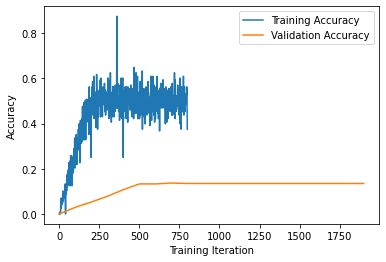

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()